In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import eli5

from string import punctuation
from collections import defaultdict
from nltk import FreqDist
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
directory = r'C:\Users\LENOVO\Jupyter Notebook\Real or Not NLP with Disaster Tweets'

In [4]:
train = pd.read_csv(directory+'\\train.csv')
test = pd.read_csv(directory+'\\test.csv')
gt = pd.read_csv(directory+'\\submission.csv')

# Analyze the data

Text(0, 0.5, 'samples')

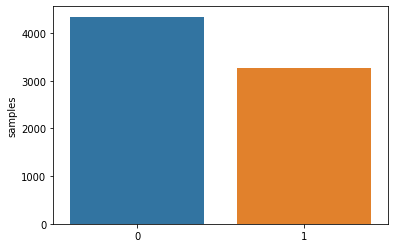

In [5]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

#### Number of characters in tweets

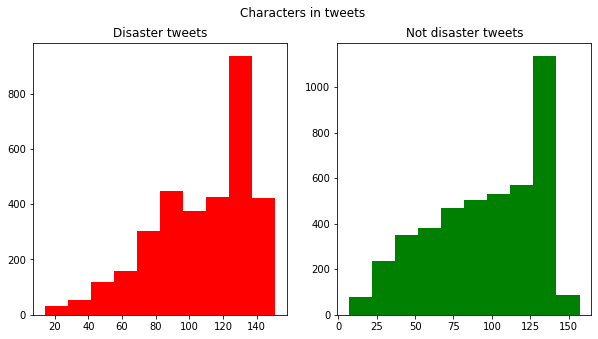

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('Disaster tweets')

tweet_len = train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Not disaster tweets')

fig.suptitle('Characters in tweets')
plt.show()

#### Number of words in a tweets

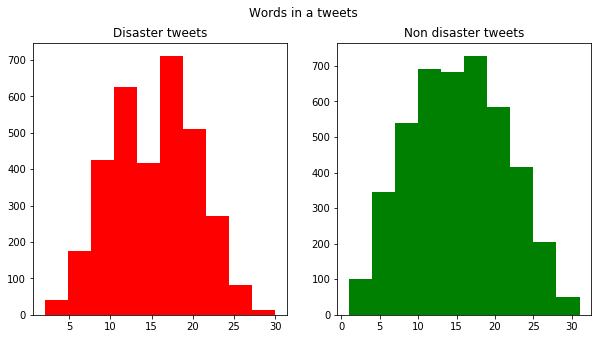

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
num_words = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(num_words, color='red')
ax1.set_title('Disaster tweets')

num_words = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(num_words, color='green')
ax2.set_title('Non disaster tweets')

fig.suptitle('Words in a tweets')
plt.show()

#### Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

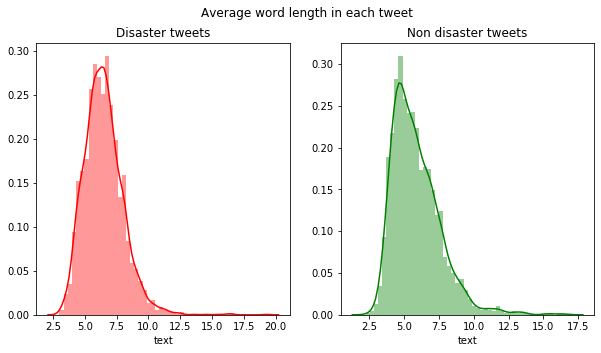

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
word = train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Disaster tweets')

word = train[train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Non disaster tweets')

fig.suptitle('Average word length in each tweet')

#### Common words in tweets

In [9]:
text_disaster = train[train['target']==1]['text'].str.split()
text_Nodisaster = train[train['target']==0]['text'].str.split()

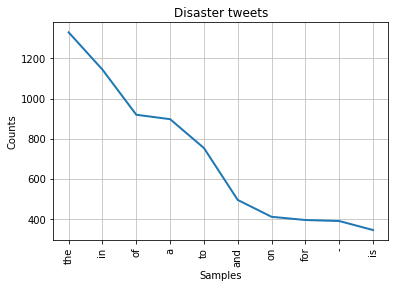

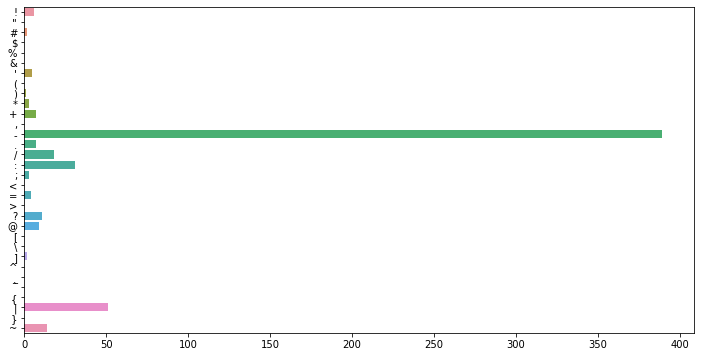

In [10]:
fdist = FreqDist(word.lower() for sentence in text_disaster for word in sentence)
fdist.plot(10, title="Disaster tweets")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

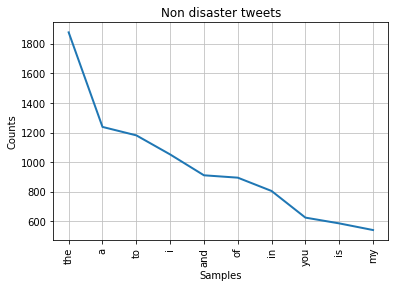

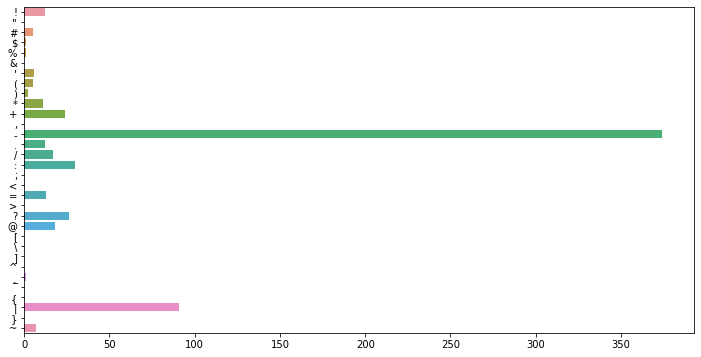

In [11]:
fdist = FreqDist(word.lower() for sentence in text_Nodisaster for word in sentence)
fdist.plot(10, title="Non disaster tweets")

dic=defaultdict(int)
punct = [fdist[p] for p in punctuation]
plt.figure(figsize=(12, 6))
sns.barplot(punct, list(punctuation))

#### Bigram analysis

In [12]:
def get_top_tweet_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

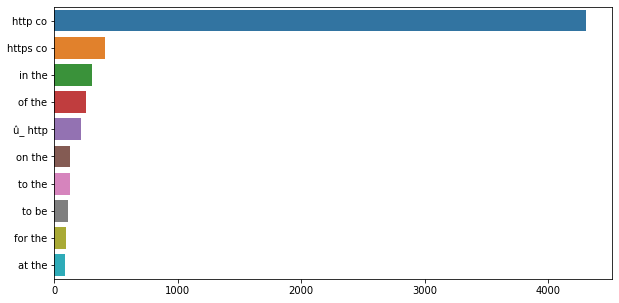

In [13]:
plt.figure(figsize=(10,5))
top_tweet_bigram = get_top_tweet_bigram(train['text'].tolist())[:10]
x,y = map(list, zip(*top_tweet_bigram))
sns.barplot(y,x)

# Clean the data

In [14]:
train = train.fillna('.')
test = test.fillna('.')

In [16]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [17]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [18]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [37]:
def preprocessing(re_URL, re_emoji, re_punct):
    data_train = train['keyword'] +' '+ train['location'] +' '+ train['text']
    data_test = test['keyword'] +' '+ test['location'] +' '+ test['text']

    if remove_URL:
        data_train = data_train.apply(lambda x : remove_URL(x))
        data_test = data_test.apply(lambda x : remove_URL(x))
    if remove_emoji:
        data_train = data_train.apply(lambda x : remove_emoji(x))
        data_test = data_test.apply(lambda x : remove_emoji(x))
    if remove_punct:
        data_train = data_train.apply(lambda x : remove_punct(x))     
        data_test = data_test.apply(lambda x : remove_punct(x))
    return data_train, data_test

# Model Training

In [46]:
def fit_and_predict(vec, clf):
    pipe = make_pipeline(vec, clf)
    pipe.fit(X_train, y_train)
    
    y_test = gt['target'].tolist()
    acc = pipe.score(X_test, y_test)
    print("Accuracy: ", acc)

#### Baseline

In [95]:
train['sums'] = train['keyword'] +' '+ train['location'] +' '+ train['text']
test['sums'] = test['keyword'] +' '+ test['location'] +' '+ test['text']

X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2))
clf = LogisticRegression()
fit_and_predict(vec, clf)

Accuracy:  0.7955868832362857


#### Baseline add stopword

In [99]:
train['sums'] = train['keyword'] +' '+ train['location'] +' '+ train['text']
test['sums'] = test['keyword'] +' '+ test['location'] +' '+ test['text']

X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf)

Accuracy:  0.8035550107263255


#### Remove URL, emoji, and punctuation

In [103]:
train['sums'], test['sums'] = preprocessing(re_URL=True, re_emoji=True, re_punct=True)
X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf)

Accuracy:  0.7971192154459087


#### Remove URL and punctuation

In [104]:
train['sums'], test['sums'] = preprocessing(re_URL=True, re_emoji=False, re_punct=True)
X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf)

Accuracy:  0.7971192154459087


#### Remove punctuation

In [105]:
train['sums'], test['sums'] = preprocessing(re_URL=False, re_emoji=False, re_punct=True)
X_train = train['sums'].tolist()
y_train = train['target'].tolist()
X_test = test['sums'].tolist()

vec = CountVectorizer(ngram_range=(1,2), lowercase=True, stop_words='english')
clf = LogisticRegression()
fit_and_predict(vec, clf)

Accuracy:  0.7971192154459087


# ELI5 analysis

#### Baseline

In [96]:
eli5.show_weights(clf, vec=vec, top=10)

In [97]:
eli5.show_prediction(clf, X_test[0], vec=vec, target_names=['0', '1'])

In [111]:
eli5.show_prediction(clf, X_test[-2], vec=vec, target_names=['0', '1'])

#### Baseline add stopword

In [100]:
eli5.show_weights(clf, vec=vec, top=10)

In [101]:
eli5.show_prediction(clf, X_test[0], vec=vec, target_names=['0', '1'])

In [110]:
eli5.show_prediction(clf, X_test[-2], vec=vec, target_names=['0', '1'])

#### Remove URL, emoji, and punctuation

In [106]:
eli5.show_weights(clf, vec=vec, top=10)

In [107]:
eli5.show_prediction(clf, X_test[0], vec=vec, target_names=['0', '1'])

In [109]:
eli5.show_prediction(clf, X_test[-2], vec=vec, target_names=['0', '1'])